In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("data/서울시_상권_추정매출.csv")

print("=" * 70)
print("데이터 불러오기 완료")
print("=" * 70)
print(f"총 레코드 수: {len(df):,}개")
print(f"컬럼 수: {len(df.columns)}개")
print(f"\n데이터 미리보기:")
print(df.head())

데이터 불러오기 완료
총 레코드 수: 20개
컬럼 수: 13개

데이터 미리보기:
    상권_코드     상권_명    행정동 업종_대분류 업종_중분류  점포수     총매출   유동인구   주거인구   직장인구  \
0  100001   강남역 상권   강남역동     소매     잡화  122  415838  23575  12964  14284   
1  100002  홍대입구 상권  홍대입구동     소매    화장품  117  225203  29495  17023   4685   
2  100003    명동 상권    명동동    서비스     세탁   93  153355   8420  18568  22769   
3  100004  건대입구 상권  건대입구동     소매    화장품   71  199503   4747   1189  22118   
4  100005    잠실 상권    잠실동     음식     양식  130  578178  10838  15502  24777   

   평균_영업기간  신규점포수  폐업점포수  
0      2.1      3      6  
1      1.4      8      3  
2      4.7      9      0  
3      5.3      7      3  
4      7.6      2      1  


In [2]:

import pandas as pd
import numpy as np

# 랜덤 시드 고정 (재현 가능)
np.random.seed(42)

# 상권, 업종 정보
districts = [
    "강남역", "홍대입구", "명동", "건대입구", "잠실", 
    "이태원", "신촌", "압구정", "사당", "노량진",
    "종로3가", "성수", "선릉", "구로디지털", "수유",
    "왕십리", "천호", "상봉", "신림", "목동"
]

categories = ["음식", "서비스", "소매"]
subcategories = {
    "음식": ["한식", "중식", "양식", "일식", "분식"],
    "서비스": ["미용", "세탁", "수리", "숙박", "학원"],
    "소매": ["편의점", "의류", "화장품", "잡화", "서점"]
}

# 데이터 생성
data = []
for i, district in enumerate(districts, start=1):
    main_cat = np.random.choice(categories)
    sub_cat = np.random.choice(subcategories[main_cat])
    stores = np.random.randint(30, 150)
    sales = np.random.randint(50000, 600000)
    floating = np.random.randint(2000, 30000)
    residential = np.random.randint(1000, 20000)
    office = np.random.randint(3000, 40000)
    years = round(np.random.uniform(1, 8), 1)
    new_stores = np.random.randint(1, 10)
    closed_stores = np.random.randint(0, 8)
    
    data.append([
        100000 + i, f"{district} 상권", f"{district}동", main_cat, sub_cat,
        stores, sales, floating, residential, office, years, new_stores, closed_stores
    ])

# 컬럼 정의
columns = [
    "상권_코드", "상권_명", "행정동", "업종_대분류", "업종_중분류",
    "점포수", "총매출", "유동인구", "주거인구", "직장인구",
    "평균_영업기간", "신규점포수", "폐업점포수"
]

# DataFrame 생성
df = pd.DataFrame(data, columns=columns)

# CSV 파일로 저장
save_path = "서울시_상권_추정매출.csv"
df.to_csv(save_path, index=False, encoding="utf-8-sig")

print(f"✅ CSV 파일 생성 완료: {save_path}")
print(df.head())


✅ CSV 파일 생성 완료: 서울시_상권_추정매출.csv
    상권_코드     상권_명    행정동 업종_대분류 업종_중분류  점포수     총매출   유동인구   주거인구   직장인구  \
0  100001   강남역 상권   강남역동     소매     잡화  122  415838  23575  12964  14284   
1  100002  홍대입구 상권  홍대입구동     소매    화장품  117  225203  29495  17023   4685   
2  100003    명동 상권    명동동    서비스     세탁   93  153355   8420  18568  22769   
3  100004  건대입구 상권  건대입구동     소매    화장품   71  199503   4747   1189  22118   
4  100005    잠실 상권    잠실동     음식     양식  130  578178  10838  15502  24777   

   평균_영업기간  신규점포수  폐업점포수  
0      2.1      3      6  
1      1.4      8      3  
2      4.7      9      0  
3      5.3      7      3  
4      7.6      2      1  


In [3]:
# 데이터 품질 확인
# 1. 결측치 확인
(df.isna().sum())[df.isna().sum() > 0]
# 2. 중복데이터 확인
df[df.duplicated()]
# 3. 데이터 타입 확인
pd.DataFrame(df.dtypes).T
# 4. 기술통계
df.describe(include=object)

,상권_명,행정동,업종_대분류,업종_중분류
count,20,20,20,20
unique,20,20,3,9
top,강남역 상권,강남역동,음식,화장품
freq,1,1,9,4


In [4]:
# 데이터 전처리
    # 결측치 확인 및 제거 또는 대처
    # 이상치 제거  IQR = Q3- Q1      [Q1 - 1.5xIQR   ~~~    Q3 + 1.5xIQR]
    # 파생변수 생성
        # 평일 총 매출,  주말 총 매출, 평일과주말비율
        # 날자가 있는경우 주말과 공휴일 여부  0 / 1
        # 비율, 점유율, 할인율 등.... 기존데이터로 새로운 피처를 생성

In [6]:
# 이상치 여부 확인  월 매출금액
# quantile(0.25)
# boxplot
seoul_df = pd.read_csv('서울시 상권분석서비스(추정매출-상권)_2024년.csv')
seoul_df.columns = seoul_df.columns.str.replace('_',"")
seoul_df.columns = seoul_df.columns.str.replace('연령대10매출금액','10대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대20매출금액','20대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대30매출금액','30대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대40매출금액','40대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대50매출금액','50대매출금액')
seoul_df.columns = seoul_df.columns.str.replace('연령대60이상매출금액','60대이상매출금액')


In [7]:
seoul_df.to_csv('서울시 상권분석서비스(추정매출-상권)_2024년.csv',encoding='utf-8')

In [8]:
# https://drive.google.com/file/d/125o7TvA2A-1xbJniSBdWTzl-3PEGv_bT/view?usp=sharing
import requests
url = "https://drive.google.com/uc?export=download&id=125o7TvA2A-1xbJniSBdWTzl-3PEGv_bT"
r = requests.get(url)
open('seoul.csv', 'wb').write(r.content)

32628175

In [11]:
df = pd.read_csv('seoul.csv')
df.columns = df.columns.str.replace('당월매출금액','월매출금액')
df.columns = df.columns.str.replace('당월매출건수','월매출건수')

<Axes: ylabel='월매출금액'>

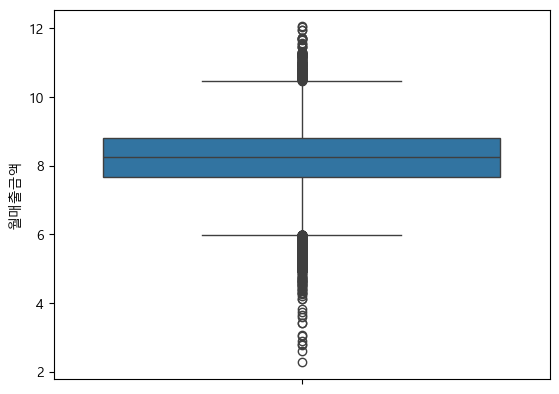

In [12]:
import seaborn as sns
np.log10(df['월매출금액'])
sns.boxplot(df, y=np.log10(df['월매출금액']))


In [13]:
# IQR
Q1 = df['월매출금액'].quantile(0.25)
Q3 = df['월매출금액'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['월매출금액'] < lower_bound) | 
                      (df['월매출금액'] > upper_bound)]

print(f"\n이상치: {len(outliers)}개 ({len(outliers)/len(df)*100:.1f}%)")
print("이상치 처리 방법 선택:")
print("  1) 제거: 분석에서 제외")
print("  2) 유지: 특별한 케이스로 별도 분석")
print("  → 프로젝트 목적에 따라 결정")


이상치: 10689개 (12.3%)
이상치 처리 방법 선택:
  1) 제거: 분석에서 제외
  2) 유지: 특별한 케이스로 별도 분석
  → 프로젝트 목적에 따라 결정


In [14]:
print(set(df['상권코드명'].unique().tolist()))

{'구암초등학교', '국민대학교앞', '영등포본동주민센터', '천동초등학교', '경춘선숲길 우측', '쌍문시장(쌍문역골목시장)', '노량진역 6번', '서울숲역', '신길6동주민센터', '서울고교교차로', 'G타워', '대림성모병원', '뚝섬역교차로', '정독도서관', '난우중학교', '도성초등학교', '연신내우체국', '남성역골목시장', '조양시장', '굽은다리역', '남산골공원옆', '서울독일학교', '평화시장(남평화시장, 제일평화시장, 신평화패션타운)', '장위1동주민센터', '서울지방병무청', '군자역', '삼전역 4번', '길동역', '암사역 1번', '서울축산농협 독산역지점(독산파출소)', '방배노인종합복지관(이수중학교)', '압구정로데오역(압구정로데오)', '옥정중학교', '개포고등학교', '무너미어린이공원', '화계중학교', '상월곡역 1번', '신길동홍어거리', '금호삼성래미안아파트', '미성초등학교', '신곡종합시장(신월6동 골목시장)', '계남근린공원', '방학동도깨비시장', '중랑역 1번', '성동구립금호도서관', '매봉역', '문정동성당', '연희사러가', '염창무학아파트', '마포구청역 1번', '장위동성당', '영중로', '방학중학교', '오류고등학교', '대림상가(청계상가)', '가오리역 1번', '왕십리파출소', '은행사거리', '대치사거리', '독립문역 1번', '강남역', '목동사거리', '석관고등학교', '창동중학교', '용마문화복지센터', '역삼역 4번', '구의사거리', '신길역 3번', '남부터미널역 1번', '잠실새내역(신천)', '장안초등학교', '은곡마을(은곡마을공원)', '청담사거리(청담동명품거리)', '신당역 3번', '창동역상점가', '남구로역 3번', '경수초등학교', '신중초등학교', '양재화물트럭터미널앞', '연신내역 2번', '신자초등학교', '석촌고분역 3번', '종각역', '신월중학교', '남구로역 5번', '대신시장', '망우본동주민센터', '대림역', '갈산공원', '구로구민회관', '신림역(신

In [ ]:
%pip install geopy

In [15]:
from geopy.geocoders import Nominatim
def get_name(x):
    try:
        geolocator = Nominatim(user_agent="my_app")
        location = geolocator.geocode(x)
        return location.address.split(',')[-3:-6:-1]
    except:
        return [np.nan, np.nan, np.nan]
get_name('이북5도청사')

[' 서울특별시', ' 종로구', ' 평창동']

In [ ]:
temp = df['상권코드명'].apply(get_name)

In [ ]:
# df['도시'] = df['상권코드명'].apply(get_name)[0]
# df['시군구명'] = df['상권코드명'].apply(get_name)[1]
# df['행정동명'] = df['상권코드명'].apply(get_name)[2]

1
예외발생
3
